In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import zipfile
import cv2
import plotly.express as px
import tensorflow as tf
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

In [2]:
sales_df=pd.read_csv("/kaggle/input/sample-sales-data/sales_data_sample.csv", encoding = 'unicode_escape')
sales_df

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,...,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,8/25/2003 0:00,Shipped,3,8,2003,...,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,10/10/2003 0:00,Shipped,4,10,2003,...,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,10350,20,100.00,15,2244.40,12/2/2004 0:00,Shipped,4,12,2004,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Small
2819,10373,29,100.00,1,3978.51,1/31/2005 0:00,Shipped,1,1,2005,...,Torikatu 38,NaN,Oulu,NaN,90110,Finland,EMEA,Koskitalo,Pirkko,Medium
2820,10386,43,100.00,4,5417.57,3/1/2005 0:00,Resolved,1,3,2005,...,"C/ Moralzarzal, 86",NaN,Madrid,NaN,28034,Spain,EMEA,Freyre,Diego,Medium
2821,10397,34,62.24,1,2116.16,3/28/2005 0:00,Shipped,1,3,2005,...,1 rue Alsace-Lorraine,NaN,Toulouse,NaN,31000,France,EMEA,Roulet,Annette,Small


In [3]:
sales_df.dtypes

ORDERNUMBER           int64
QUANTITYORDERED       int64
PRICEEACH           float64
ORDERLINENUMBER       int64
SALES               float64
ORDERDATE            object
STATUS               object
QTR_ID                int64
MONTH_ID              int64
YEAR_ID               int64
PRODUCTLINE          object
MSRP                  int64
PRODUCTCODE          object
CUSTOMERNAME         object
PHONE                object
ADDRESSLINE1         object
ADDRESSLINE2         object
CITY                 object
STATE                object
POSTALCODE           object
COUNTRY              object
TERRITORY            object
CONTACTLASTNAME      object
CONTACTFIRSTNAME     object
DEALSIZE             object
dtype: object

In [4]:
sales_df["ORDERDATE"]=pd.to_datetime(sales_df["ORDERDATE"])

In [5]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       2823 non-null   int64         
 1   QUANTITYORDERED   2823 non-null   int64         
 2   PRICEEACH         2823 non-null   float64       
 3   ORDERLINENUMBER   2823 non-null   int64         
 4   SALES             2823 non-null   float64       
 5   ORDERDATE         2823 non-null   datetime64[ns]
 6   STATUS            2823 non-null   object        
 7   QTR_ID            2823 non-null   int64         
 8   MONTH_ID          2823 non-null   int64         
 9   YEAR_ID           2823 non-null   int64         
 10  PRODUCTLINE       2823 non-null   object        
 11  MSRP              2823 non-null   int64         
 12  PRODUCTCODE       2823 non-null   object        
 13  CUSTOMERNAME      2823 non-null   object        
 14  PHONE             2823 n

In [6]:
sales_df.isna().sum()

ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [7]:
# since there are lot of Null values in 'addressline2', 'state', 'postal code' and 'territory' we can drop them. 
# Country would represent the order grographical information.
# Also we can drop city, address1, phone number, contact_name, contact last_name and contact first_name since they are not required for the analysis
df_drop=['ADDRESSLINE1', 'ADDRESSLINE2', 'POSTALCODE', 'CITY', 'TERRITORY', 'PHONE', 'STATE', 'CONTACTFIRSTNAME', 'CONTACTLASTNAME', 'CUSTOMERNAME', 'ORDERNUMBER']
sales_df=sales_df.drop(df_drop,axis=1)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,USA,Medium


In [8]:
sales_df.isna().sum()

QUANTITYORDERED    0
PRICEEACH          0
ORDERLINENUMBER    0
SALES              0
ORDERDATE          0
STATUS             0
QTR_ID             0
MONTH_ID           0
YEAR_ID            0
PRODUCTLINE        0
MSRP               0
PRODUCTCODE        0
COUNTRY            0
DEALSIZE           0
dtype: int64

## PERFORM EXPLORATORY DATA ANALYSIS

In [9]:
sales_df['COUNTRY'].value_counts()

USA            1004
Spain           342
France          314
Australia       185
UK              144
Italy           113
Finland          92
Norway           85
Singapore        79
Canada           70
Denmark          63
Germany          62
Sweden           57
Austria          55
Japan            52
Belgium          33
Switzerland      31
Philippines      26
Ireland          16
Name: COUNTRY, dtype: int64

In [10]:
def bar_plot(z):
    fig=plt.Figure(figsize=(12,6))
    fig=px.bar(x=sales_df[z].value_counts().index,y=sales_df[z].value_counts(),color=sales_df[z].value_counts().index,height=600)
    fig.show()

In [11]:
x=bar_plot('COUNTRY')
x

In [12]:
bar_plot('STATUS')

In [13]:
sales_df.drop(columns="STATUS",inplace=True)
sales_df

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,COUNTRY,DEALSIZE
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,Motorcycles,95,S10_1678,USA,Small
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,Motorcycles,95,S10_1678,France,Small
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,Motorcycles,95,S10_1678,France,Medium
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,Motorcycles,95,S10_1678,USA,Medium
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,Motorcycles,95,S10_1678,USA,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,2004-12-02,4,12,2004,Ships,54,S72_3212,Spain,Small
2819,29,100.00,1,3978.51,2005-01-31,1,1,2005,Ships,54,S72_3212,Finland,Medium
2820,43,100.00,4,5417.57,2005-03-01,1,3,2005,Ships,54,S72_3212,Spain,Medium
2821,34,62.24,1,2116.16,2005-03-28,1,3,2005,Ships,54,S72_3212,France,Small


In [14]:
bar_plot('DEALSIZE')

In [15]:
bar_plot('PRODUCTLINE')

In [16]:
# Function to add dummy variables to replace categorical variables
def dummies(x):
    dummy = pd.get_dummies(sales_df[x])
    sales_df.drop(columns = x , inplace = True)
    return pd.concat([sales_df, dummy], axis = 1)

In [17]:
sales_df = dummies('DEALSIZE')


In [18]:
sales_df = dummies('PRODUCTLINE')


In [19]:
sales_df = dummies('COUNTRY')


In [21]:
pd.set_option('max_columns', None)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,S10_1678,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,S10_1678,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,S10_1678,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,S10_1678,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,S10_1678,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [22]:
# since we have 109 unique code so we can do this :
sales_df["PRODUCTCODE"]=pd.Categorical(sales_df["PRODUCTCODE"]).codes
pd.set_option('max_columns', None)
sales_df.head()

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2003-02-24,1,2,2003,95,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,2003-05-07,2,5,2003,95,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,2003-07-01,3,7,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,2003-08-25,3,8,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,2003-10-10,4,10,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [23]:
#I'am going to group sales by Order date 
sales_df_group = sales_df.groupby(by = "ORDERDATE").sum()
sales_df_group

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
ORDERDATE,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2003-01-06,151,288.78,10,12133.25,4,4,8012,363,174.0,0,2,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4
2003-01-09,142,284.96,10,11432.34,4,4,8012,372,181.0,0,2,2,0,0,0,0,0,0,4,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
2003-01-10,80,150.14,3,6864.05,2,2,4006,155,37.0,0,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
2003-01-29,541,1417.54,136,54702.00,16,16,32048,1695,723.0,0,10,6,3,0,0,0,0,7,6,0,0,0,0,0,0,0,0,0,0,0,16,0,0,0,0,0,0,0
2003-01-31,443,1061.89,91,44621.96,13,13,26039,1365,720.0,0,8,5,7,0,0,0,2,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-05-13,259,561.18,21,31821.90,12,30,12030,728,101.0,2,3,1,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0
2005-05-17,509,1269.43,105,59475.10,28,70,28070,1669,462.0,2,8,4,14,0,0,0,0,0,0,0,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2005-05-29,607,1148.40,94,51233.18,30,75,30075,1328,797.0,0,8,7,7,0,0,0,0,0,8,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2


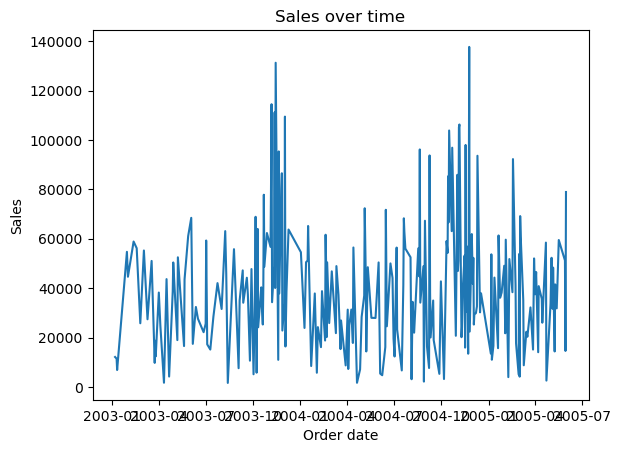

In [26]:
import matplotlib.pyplot as plt

# plot the sales data
plt.plot(sales_df_group.index, sales_df_group["SALES"])

# set the plot title and axis labels
plt.title("Sales over time")
plt.xlabel("Order date")
plt.ylabel("Sales")

# show the plot
plt.show()
#------------------------------------------------------
fig = px.line(x = sales_df_group.index, y = sales_df_group.SALES, title = 'Sales')
fig.show()
#you have to choose the right chart to better undrestand your data

In [27]:
# We can drop 'ORDERDATE' and keep the rest of the date-related data such as 'MONTH' and 'YEAR'
sales_df.drop("ORDERDATE", axis = 1, inplace = True)
sales_df.shape

(2823, 38)

<AxesSubplot:>

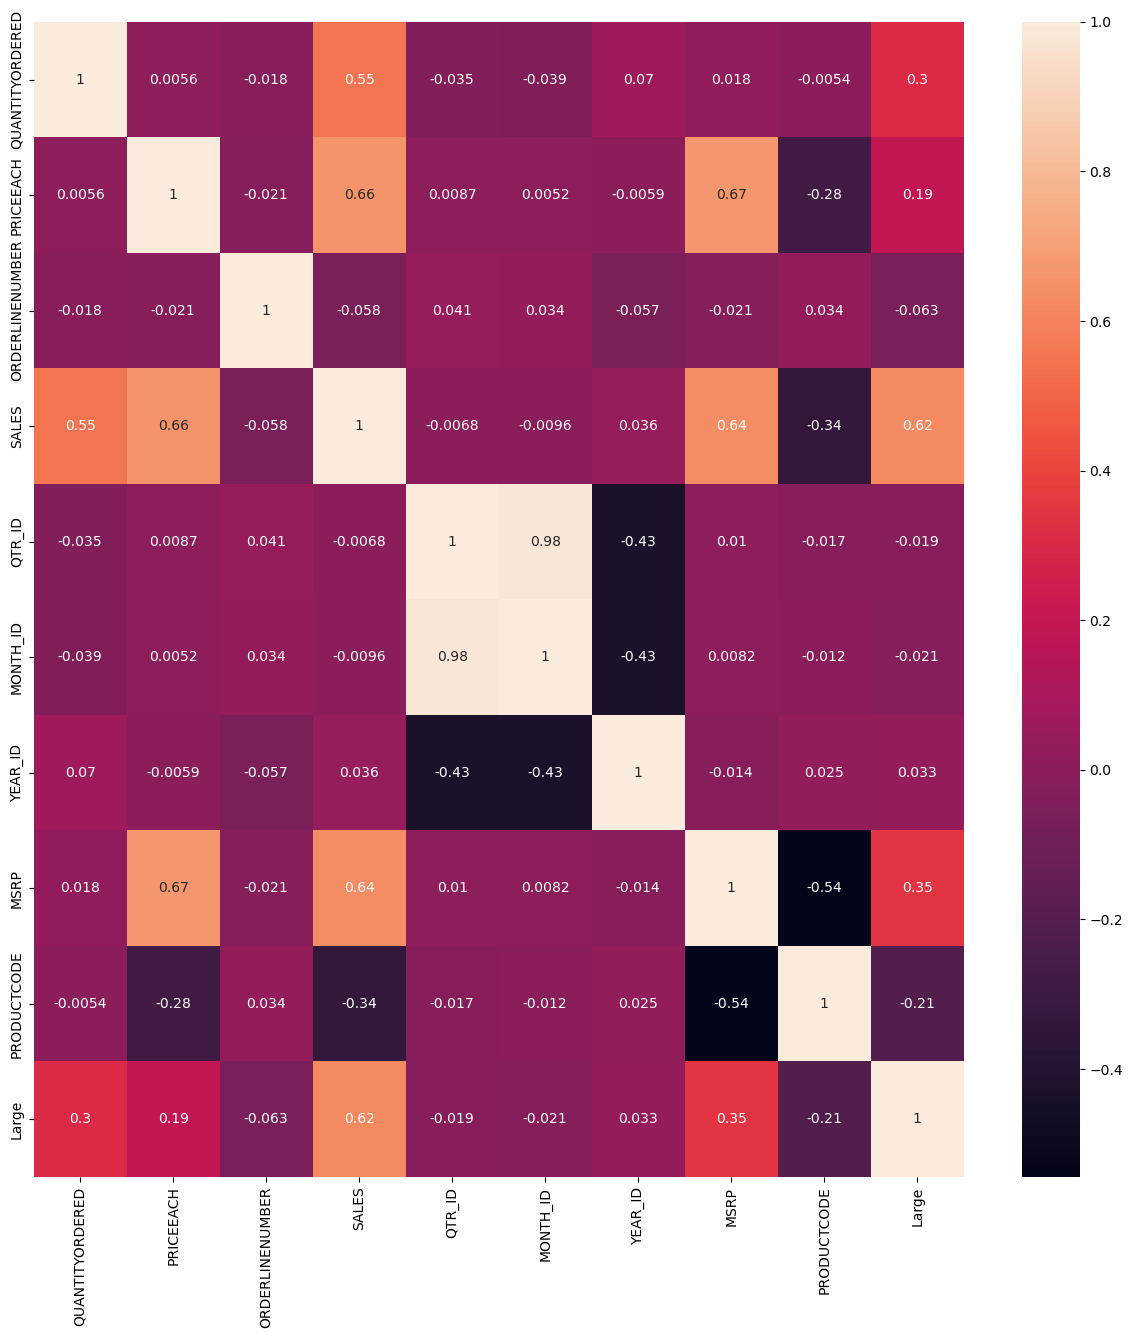

In [36]:
plt.figure(figsize=(15,15))
corr_matrix = sales_df.iloc[:, :10].corr()
sns.heatmap(corr_matrix,annot=True)

In [37]:
#QTR_ID and MONTH_ID are highly correlated so we are going to drop one of them
sales_df.drop("QTR_ID",axis=1)

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,30,95.70,2,2871.00,2,2003,95,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,34,81.35,5,2765.90,5,2003,95,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,41,94.74,2,3884.34,7,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,8,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,49,100.00,14,5205.27,10,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,12,2004,54,108,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2819,29,100.00,1,3978.51,1,2005,54,108,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2820,43,100.00,4,5417.57,3,2005,54,108,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2821,34,62.24,1,2116.16,3,2005,54,108,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


##### Visualize the relationship between variables using pairplots


In [38]:
plt.figure(figsize = (15, 15))

fig = px.scatter_matrix(sales_df,
    dimensions = sales_df.columns[:8], color = 'MONTH_ID')

fig.update_layout(
    title = 'Sales Data',
    width = 1100,
    height = 1100,
)
fig.show()

<Figure size 1500x1500 with 0 Axes>

#####   there is a correlation  between 'SALES' and 'QUANTITYORDERED'(it's obvious that the increasing of QuantityOrdered gonna increase the Sales
#####   there is a correlation between 'MSRP' and 'PRICEEACH'  
#####   there is a correlation between 'PRICEEACH' and 'SALES'

## FIND THE OPTIMAL NUMBER OF CLUSTERS USING ELBOW METHOD

### First we have to scale the Data

In [40]:
scaler = StandardScaler()
sales_df_scaled = scaler.fit_transform(sales_df)
sales_df_scaled.shape

(2823, 38)

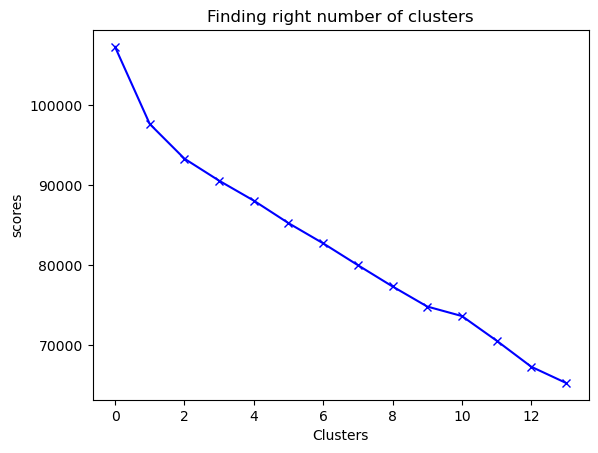

In [43]:
scores = []

range_values = range(1, 15)

for i in range_values:
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(sales_df_scaled)
    scores.append(kmeans.inertia_) 
    
plt.plot(scores, 'bx-')
plt.title('Finding right number of clusters')
plt.xlabel('Clusters')
plt.ylabel('scores') 
plt.show()

# Source  https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

#### we can observe that, 5th cluster seems to be forming the elbow of the curve

## APPLY K-MEANS

In [44]:
kmeans = KMeans(5)
kmeans.fit(sales_df_scaled)
labels = kmeans.labels_

In [46]:
kmeans.cluster_centers_.shape

(5, 38)

In [45]:
# Let's take a look at the cluster centers 
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [sales_df.columns])
cluster_centers 

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,0.294898,0.584878,-0.012421,0.462794,-0.000962,0.001168,-0.017530,0.381577,-0.171413,-0.242672,1.019676,-0.912100,0.077800,-0.008292,-0.061470,-0.017284,-0.048689,0.071593,-0.059740,-0.006243,0.015154,-0.004921,-0.001561,0.005069,0.000837,-0.010630,-0.149852,-0.016031,-0.037190,-0.020787,0.006672,0.012631,0.001755,0.009526,0.020434,0.051699,0.008262,0.041975
1,-0.466151,-0.704752,0.030844,-0.804736,-0.988320,-0.990301,0.510101,-0.562976,0.308894,-0.242672,-0.945609,1.061134,-0.252310,0.071801,0.204370,0.062054,0.015647,-0.072622,0.087280,0.018760,0.074824,0.168720,0.032335,-0.032312,0.063473,0.176319,-0.149852,0.111460,-0.061003,0.084813,-0.114597,0.032145,-0.010117,0.080358,-0.093661,0.046138,-0.040471,-0.160228
2,-0.459719,-0.730023,0.058140,-0.804931,0.791211,0.793707,-0.394807,-0.593449,0.279214,-0.242672,-0.980703,1.096370,-0.111510,-0.028540,-0.019589,0.065190,0.106778,-0.013993,0.090406,0.037964,-0.088834,-0.095351,0.016599,0.004997,-0.037468,-0.110873,-0.149852,-0.075499,0.133932,-0.019113,0.093626,-0.036078,0.022530,-0.044497,0.061336,-0.105371,0.062868,0.087829
3,-0.045961,-0.002023,-0.049255,0.001147,0.395353,0.376174,-0.219857,0.014706,-0.089862,0.038841,-0.012778,-0.005049,0.501731,-0.214050,0.066383,-0.183640,0.030586,-0.240952,-0.170039,-0.264819,-0.140961,-0.108756,-0.159458,-0.151083,-0.183541,-0.353765,6.673249,-0.075499,-0.204199,-0.136988,-0.176195,-0.096414,-0.169676,-0.371278,-0.143553,-0.105371,-0.231843,-0.742934
4,1.250053,0.799961,-0.249558,2.583369,-0.058669,-0.073558,0.133524,1.431361,-0.875120,4.120788,-0.980703,-0.912100,0.559043,0.021546,-0.159457,-0.300637,-0.127328,-0.197232,-0.141557,-0.079937,0.048193,-0.108756,-0.117427,0.114406,0.000509,0.082775,-0.149852,0.098629,0.029197,0.008833,0.015039,-0.027994,-0.011160,-0.030759,-0.050616,-0.105371,-0.113017,0.130874


In [47]:
# In order to understand what these numbers mean, let's perform inverse the scaling
cluster_centers = scaler.inverse_transform(cluster_centers)

In [49]:
cluster_centers = pd.DataFrame(data=cluster_centers , columns =[sales_df.columns])
cluster_centers

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA
0,37.965030,95.455945,6.413690,4406.142813,2.716518,7.096726,2003.802827,116.047619,48.360119,7.216450e-16,1.000000e+00,-2.220446e-16,0.379464,0.114583,0.089286,7.812500e-02,0.019345,0.128720,0.190476,6.398810e-02,2.157738e-02,1.116071e-02,2.455357e-02,2.306548e-02,3.273810e-02,1.078869e-01,-1.769418e-16,4.464286e-03,3.273810e-02,1.562500e-02,3.125000e-02,1.041667e-02,2.827381e-02,1.242560e-01,2.306548e-02,1.636905e-02,5.282738e-02,3.757440e-01
1,30.552632,69.443211,6.596491,2071.935614,1.528070,3.471930,2004.171930,78.094737,63.528070,-6.938894e-18,1.754386e-02,9.824561e-01,0.222807,0.140351,0.171930,1.000000e-01,0.029825,0.084211,0.250877,7.017544e-02,2.982456e-02,2.982456e-02,2.982456e-02,1.754386e-02,4.385965e-02,1.666667e-01,2.428613e-17,1.403509e-02,2.807018e-02,2.982456e-02,1.052632e-02,1.228070e-02,2.631579e-02,1.473684e-01,7.017544e-03,1.578947e-02,4.210526e-02,2.789474e-01
2,30.615274,68.933458,6.711816,2071.576830,3.670029,9.994236,2003.538905,76.870317,62.590778,1.595946e-16,-9.436896e-16,1.000000e+00,0.289625,0.108069,0.102305,1.008646e-01,0.044669,0.102305,0.252161,7.492795e-02,7.204611e-03,1.440922e-03,2.737752e-02,2.305476e-02,2.593660e-02,7.636888e-02,8.326673e-17,-2.602085e-17,6.628242e-02,1.585014e-02,4.610951e-02,5.763689e-03,3.170029e-02,1.066282e-01,2.881844e-02,1.561251e-17,6.484150e-02,3.976945e-01
3,34.645161,83.617742,6.258065,3556.001452,3.193548,8.467742,2003.661290,101.306452,50.935484,6.451613e-02,4.838710e-01,4.516129e-01,0.580645,0.048387,0.129032,3.225806e-02,0.032258,0.032258,0.145161,1.387779e-17,1.040834e-17,-3.469447e-18,6.938894e-18,1.387779e-17,-2.081668e-17,5.551115e-17,1.000000e+00,8.673617e-19,2.081668e-17,-1.040834e-17,-6.938894e-18,-3.469447e-18,-1.387779e-17,2.775558e-17,6.938894e-18,-3.469447e-18,-2.081668e-17,5.551115e-17
4,47.267974,99.794314,5.411765,8311.262745,2.647059,6.823529,2003.908497,158.228758,26.137255,1.000000e+00,-7.216450e-16,1.332268e-15,0.607843,0.124183,0.058824,-6.938894e-17,0.006536,0.045752,0.156863,4.575163e-02,2.614379e-02,-2.081668e-17,6.535948e-03,3.921569e-02,3.267974e-02,1.372549e-01,0.000000e+00,1.307190e-02,4.575163e-02,1.960784e-02,3.267974e-02,6.535948e-03,2.614379e-02,1.111111e-01,1.307190e-02,3.122502e-17,2.614379e-02,4.183007e-01


* I applied the K-means method in order to segment customers into groups based on their purchasing behavior.  So I am targeting the most profitable customers with the highest sales.

In [51]:
labels.shape

(2823,)

In [52]:
# predicting the cluster of each data point
y_kmeans = kmeans.fit_predict(sales_df_scaled)

In [56]:
sales_df_cluster = pd.concat([sales_df,pd.DataFrame({"Cluster":labels})],axis=1)
sales_df_cluster

,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP,PRODUCTCODE,Large,Medium,Small,Classic Cars,Motorcycles,Planes,Ships,Trains,Trucks and Buses,Vintage Cars,Australia,Austria,Belgium,Canada,Denmark,Finland,France,Germany,Ireland,Italy,Japan,Norway,Philippines,Singapore,Spain,Sweden,Switzerland,UK,USA,Cluster
0,30,95.70,2,2871.00,1,2,2003,95,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,34,81.35,5,2765.90,2,5,2003,95,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
2,41,94.74,2,3884.34,3,7,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3,45,83.26,6,3746.70,3,8,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
4,49,100.00,14,5205.27,4,10,2003,95,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,20,100.00,15,2244.40,4,12,2004,54,108,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2
2819,29,100.00,1,3978.51,1,1,2005,54,108,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2820,43,100.00,4,5417.57,1,3,2005,54,108,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2821,34,62.24,1,2116.16,1,3,2005,54,108,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1


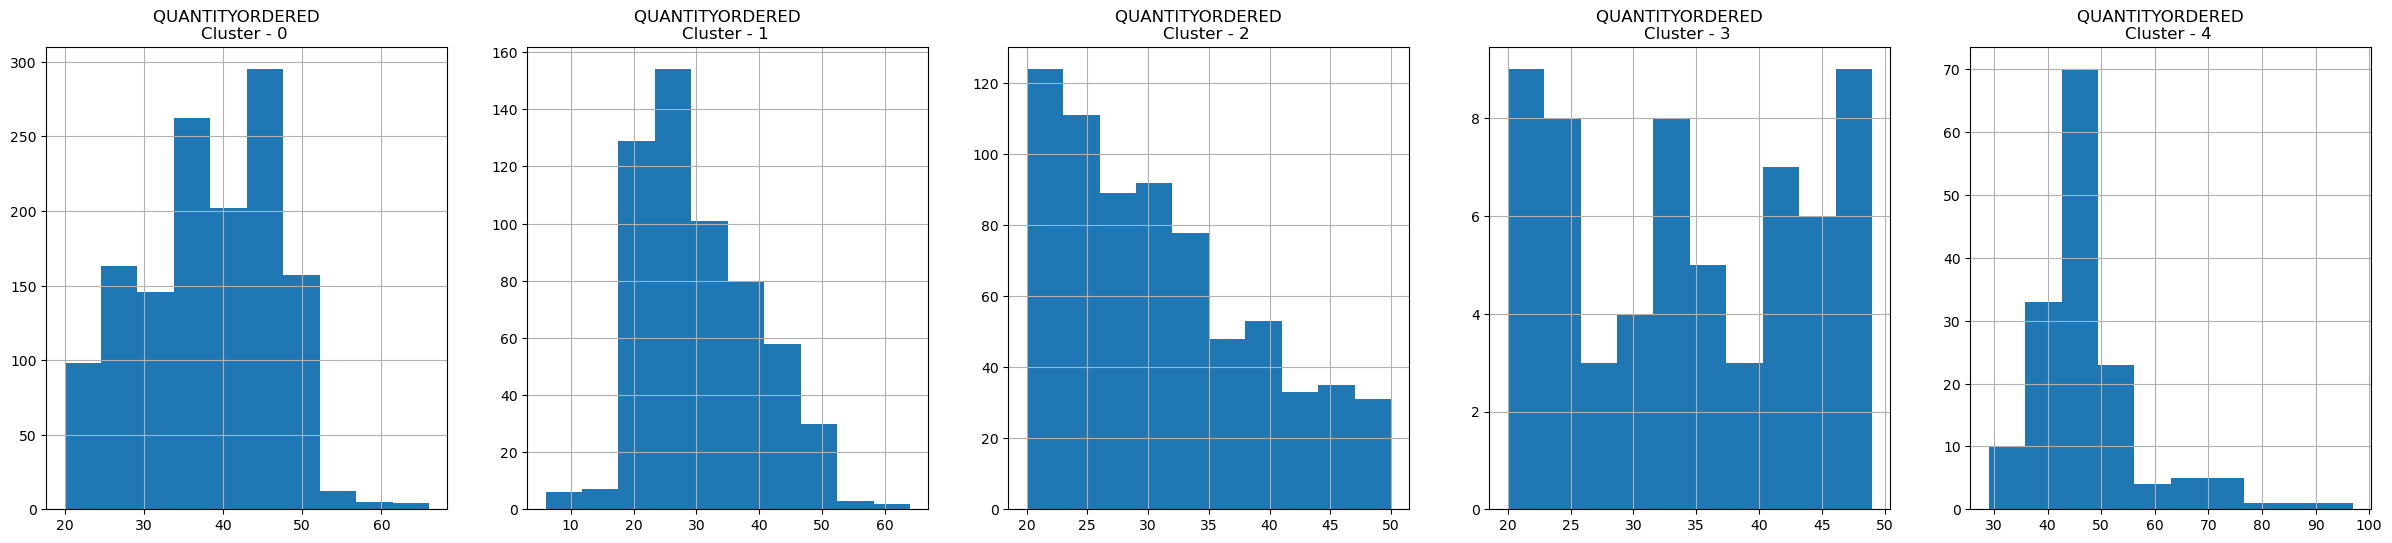

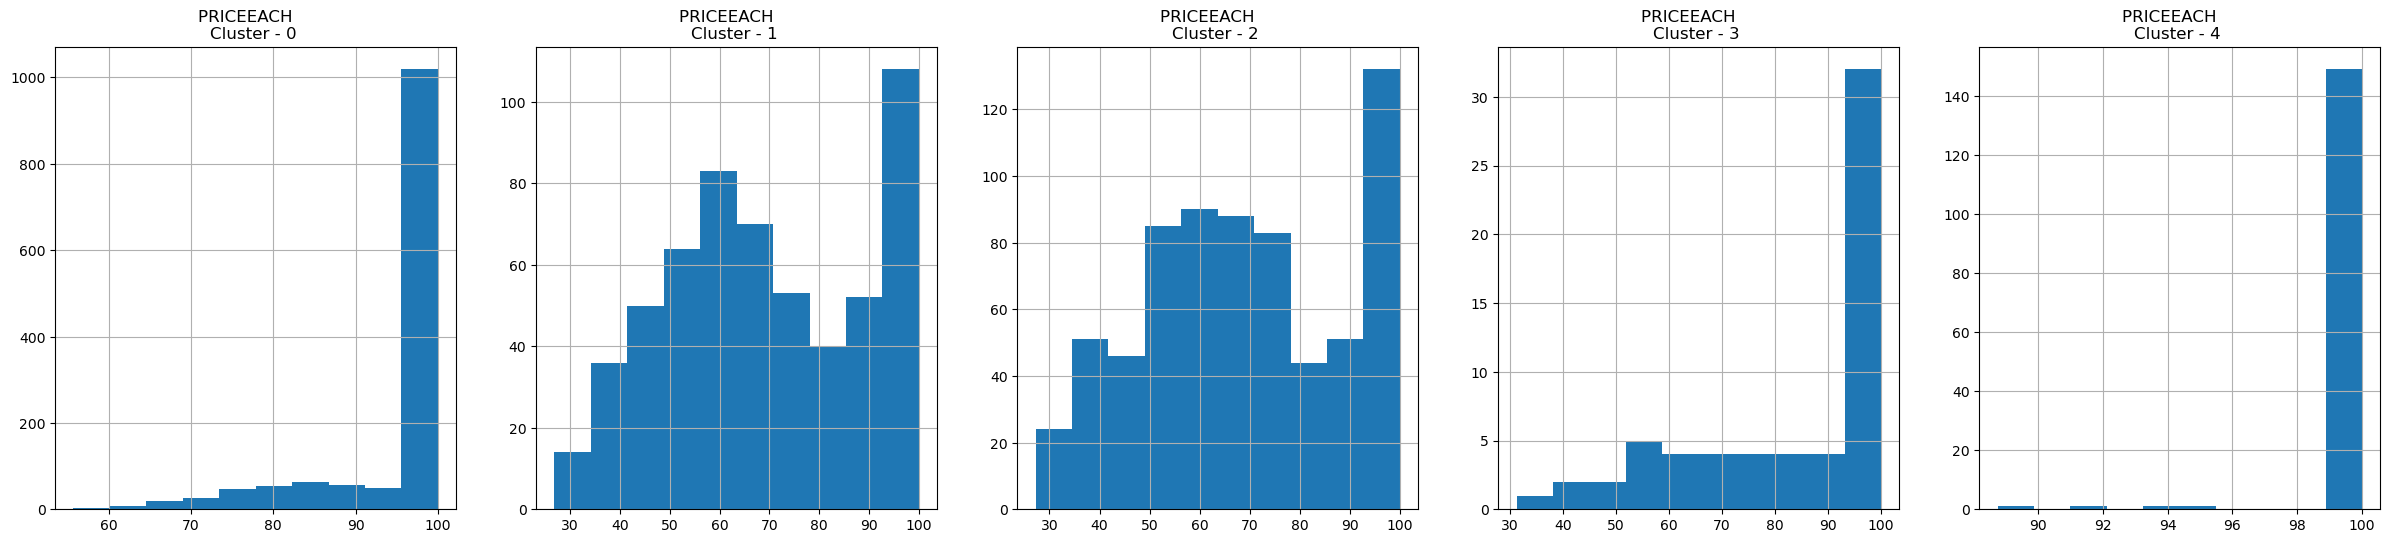

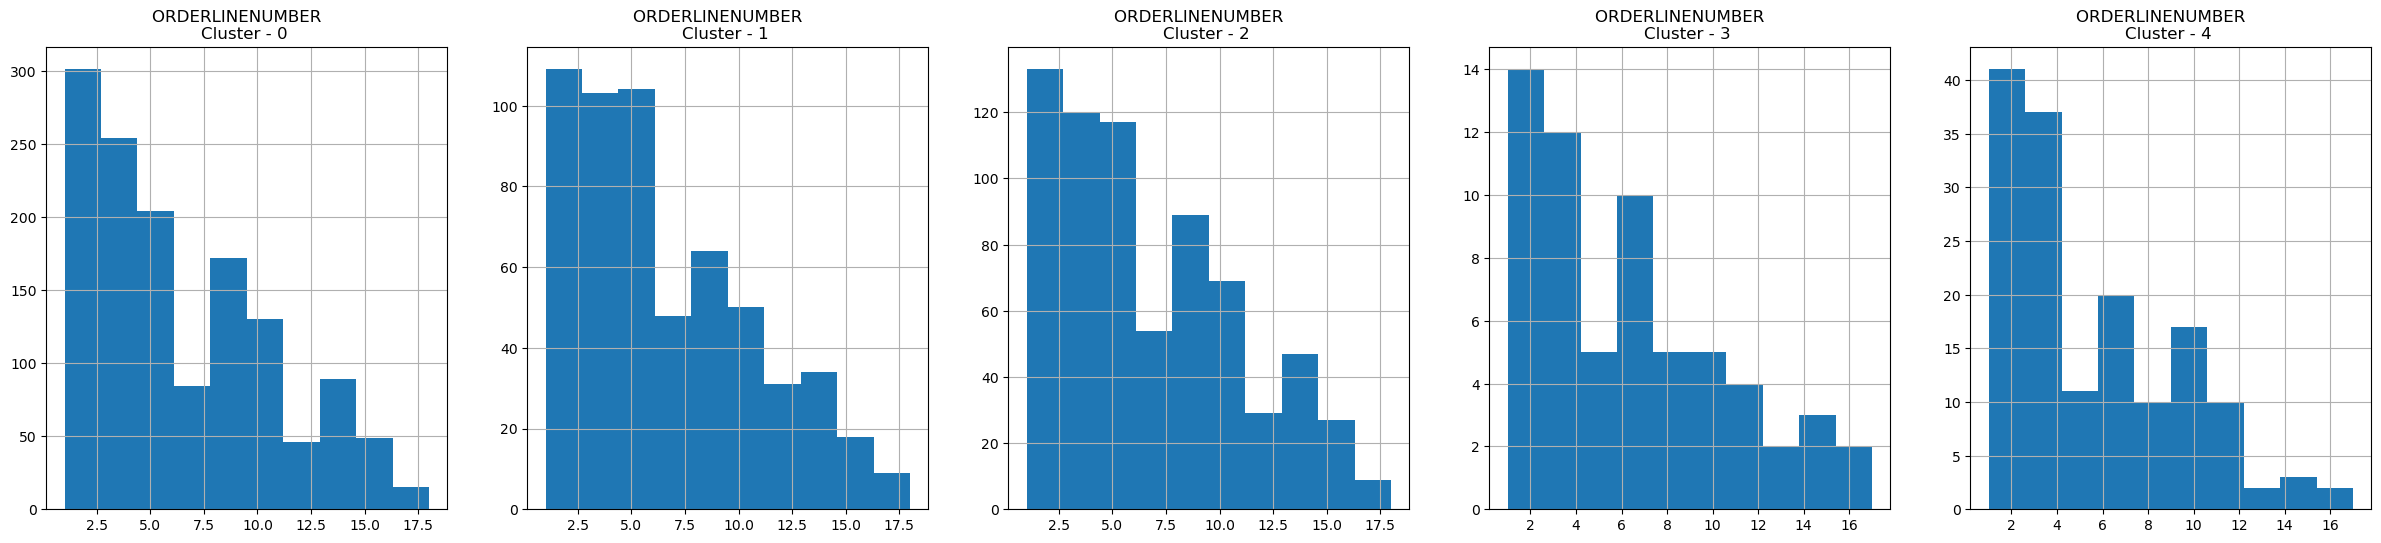

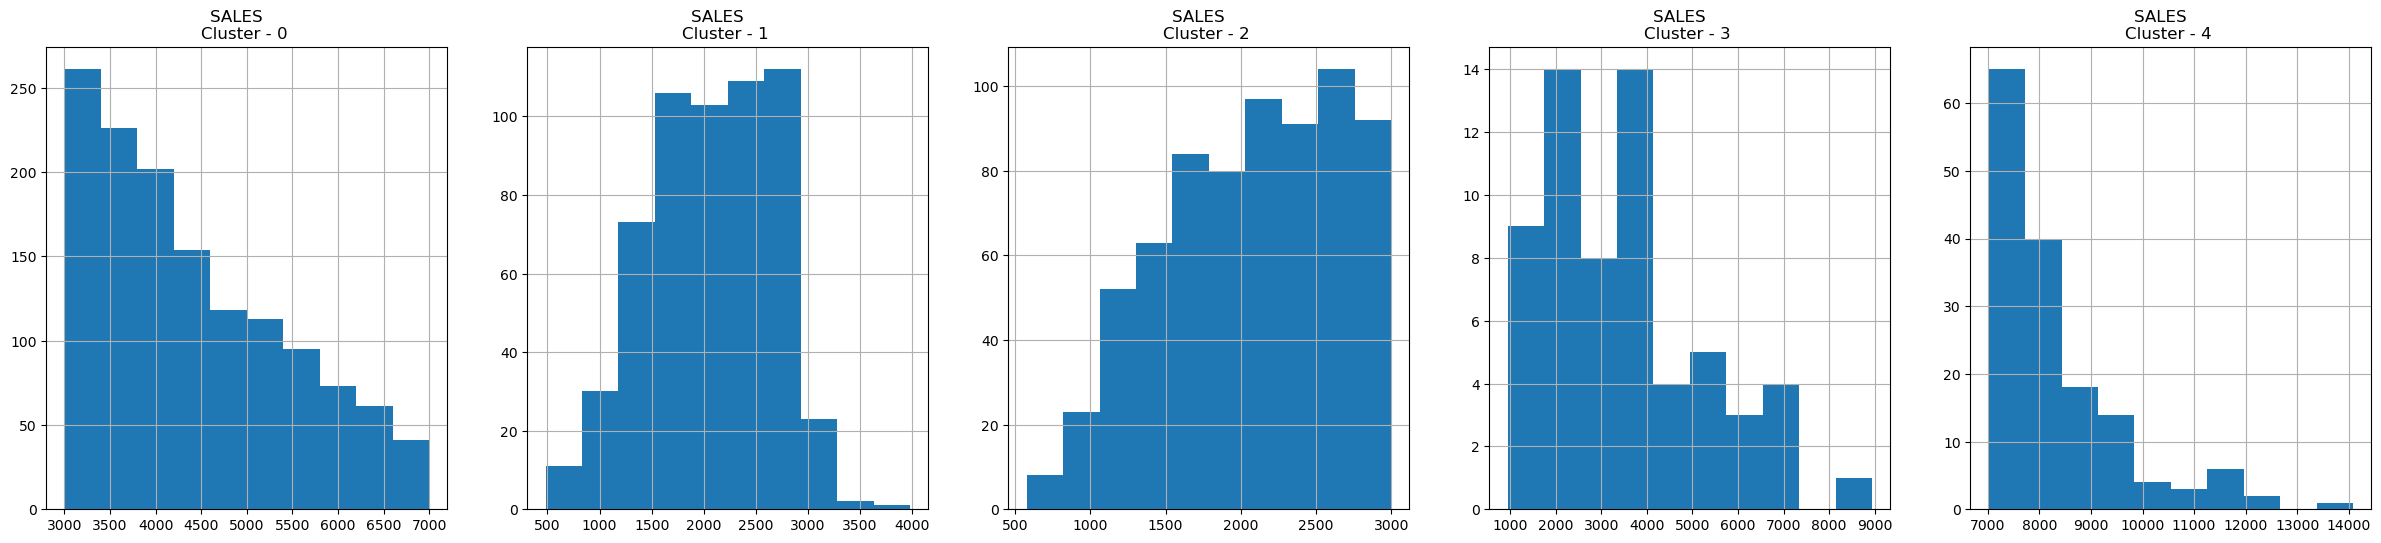

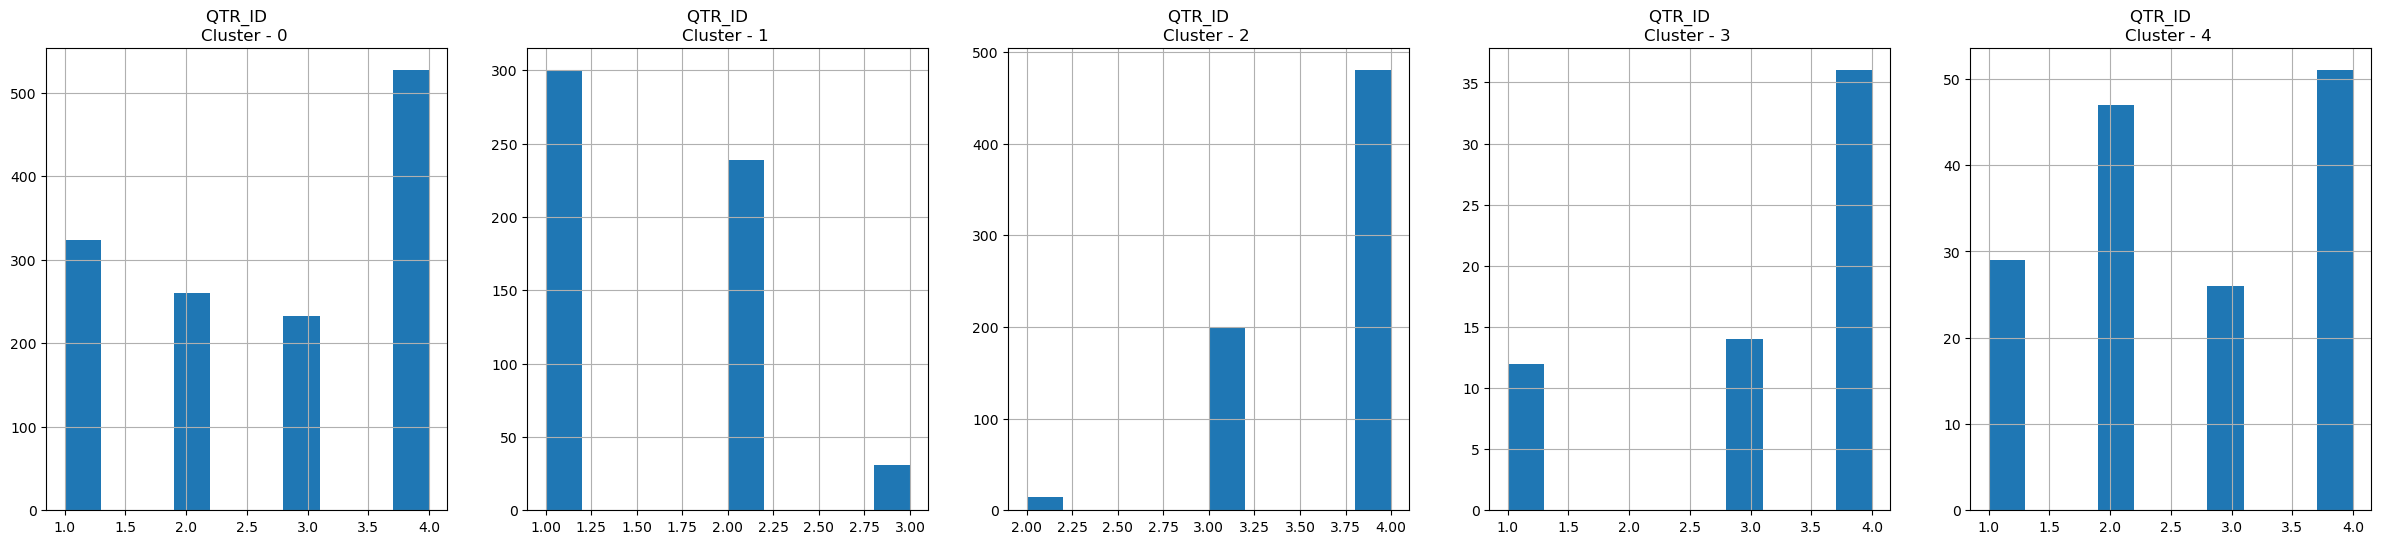

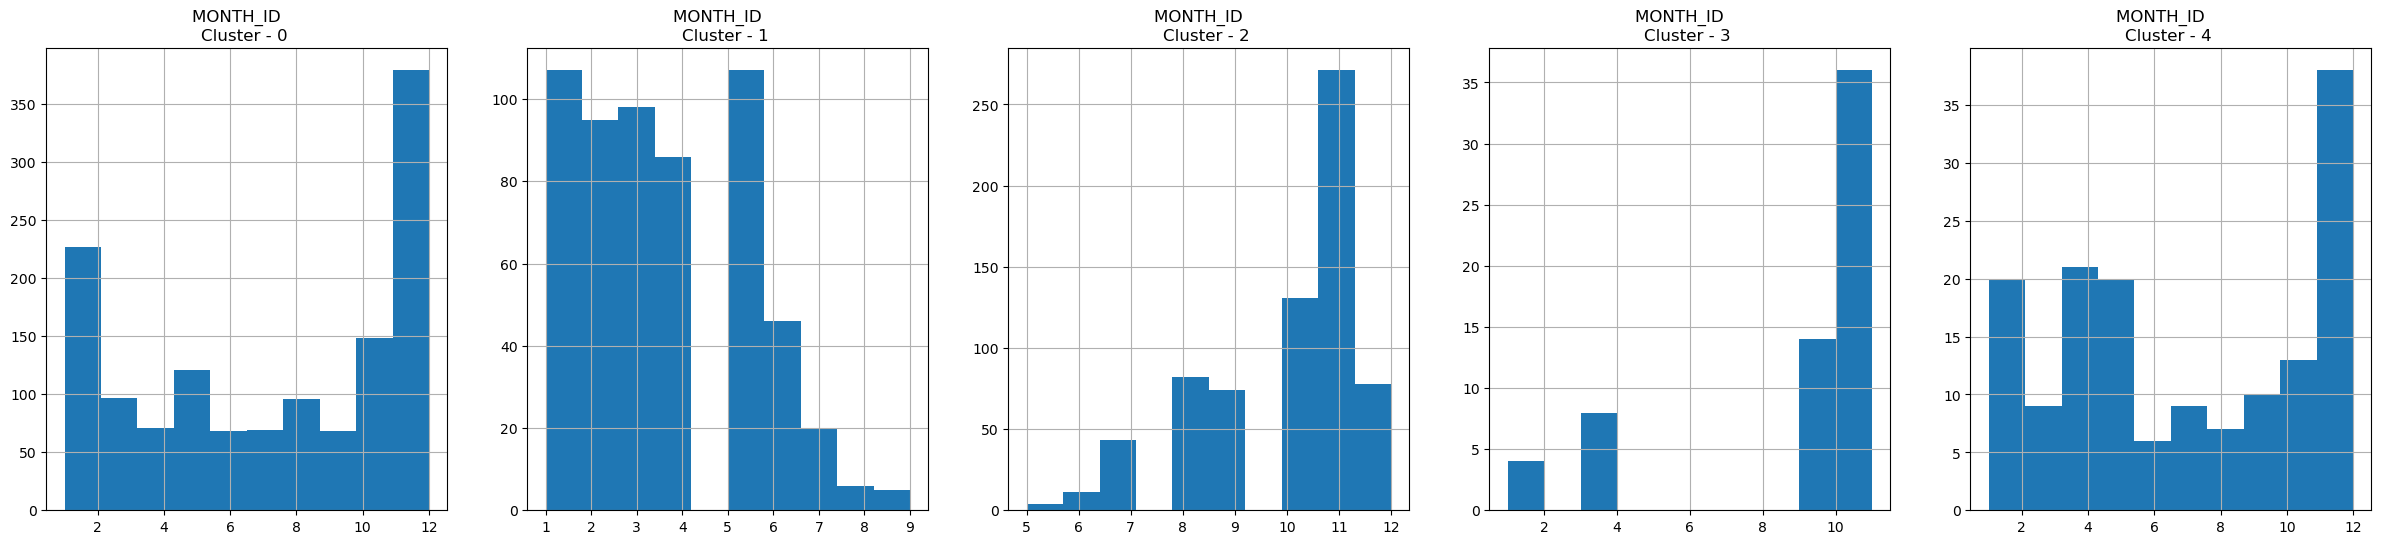

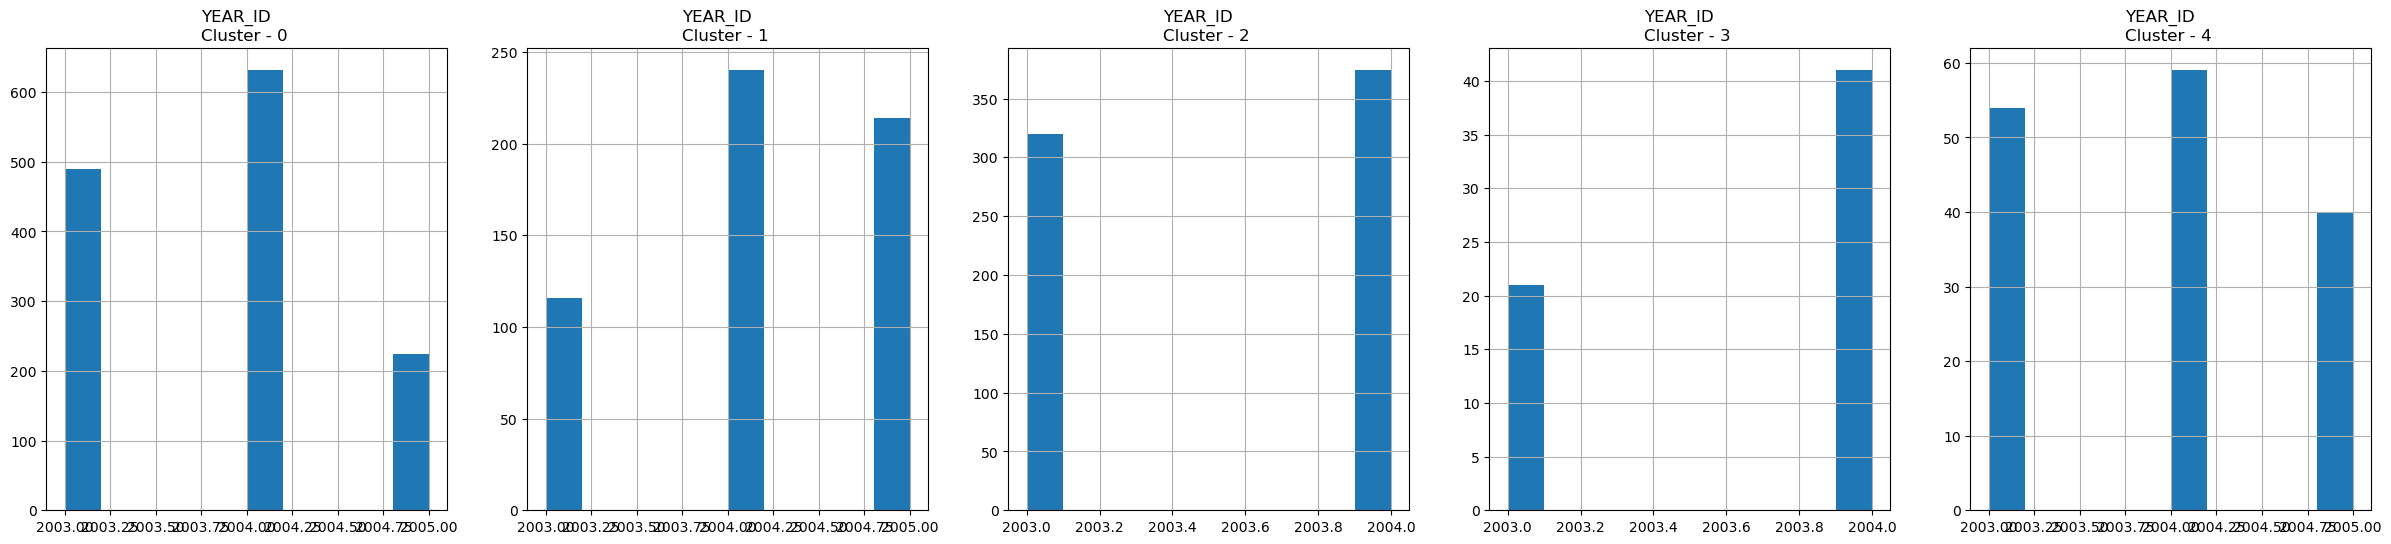

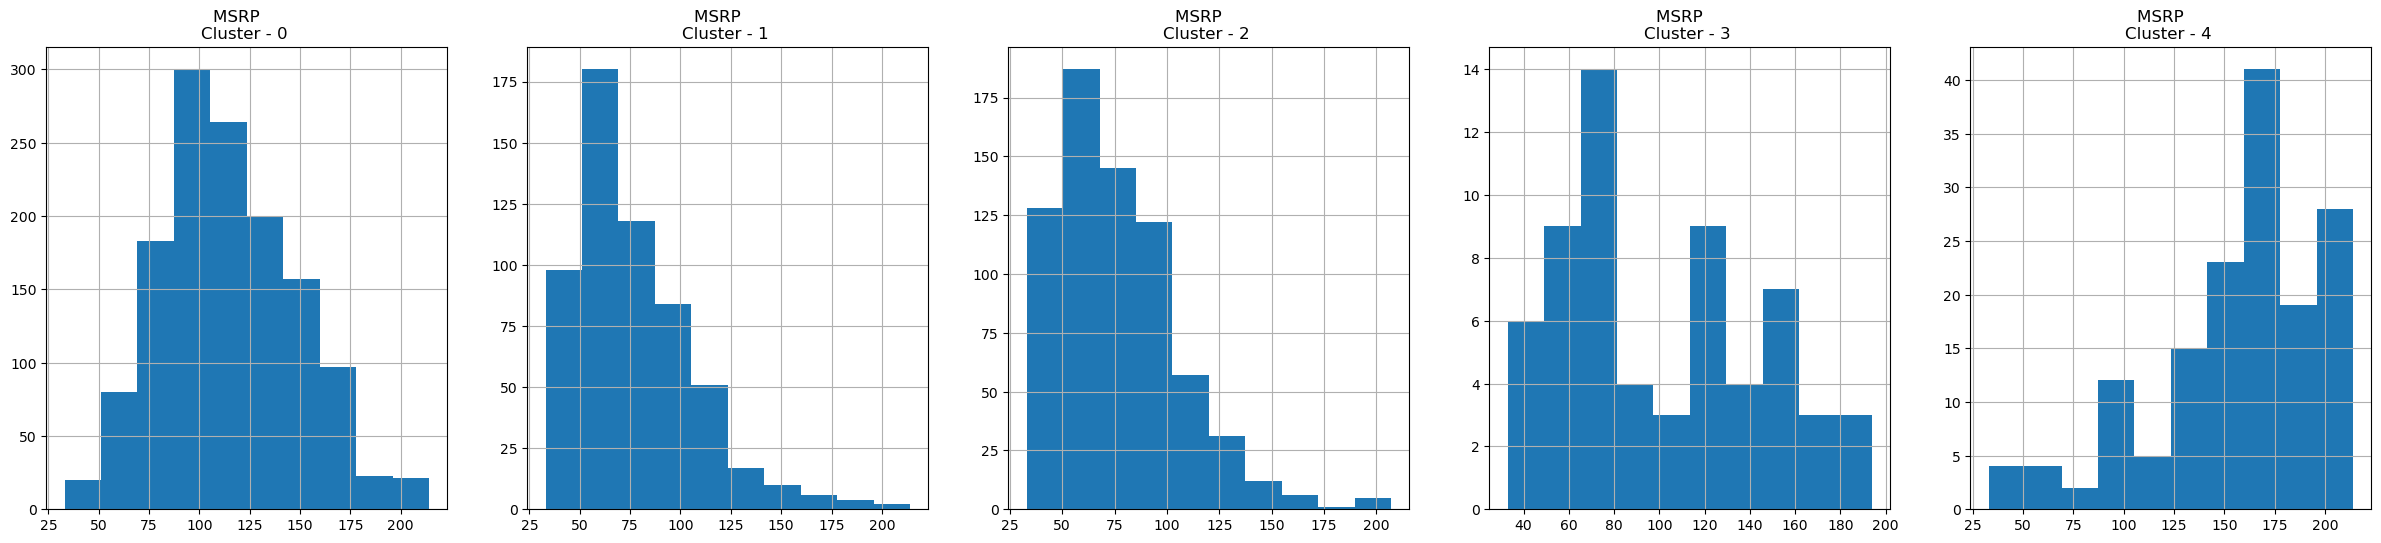

In [60]:
# plot histogram for each feature based on cluster 
for i in sales_df.columns[:8]:
  plt.figure(figsize = (30, 6))
  for j in range(5):
    plt.subplot(1, 5, j+1)
    Cluster = sales_df_cluster[sales_df_cluster['Cluster'] == j]
    Cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

## APPLY PRINCIPAL COMPONENT ANALYSIS 

In [61]:
pca=PCA(n_components=3)
principal_comp=pca.fit_transform(sales_df_scaled)
principal_comp

array([[-0.48915163,  1.06002827,  1.61456189],
       [-0.78581693,  0.53496542,  1.59140731],
       [ 1.43183259, -0.13894494, -0.07762624],
       ...,
       [ 0.38587897,  2.88108683, -3.26356648],
       [-2.79247423,  2.84967449, -0.94809855],
       [-0.70727354,  1.63091364, -2.94393311]])

In [62]:
pca_df=pd.DataFrame(data=principal_comp,columns=['pca1','pca2','pca3'])

In [64]:
pca_df.head()

,pca1,pca2,pca3
0,-0.489152,1.060028,1.614562
1,-0.785817,0.534965,1.591407
2,1.431833,-0.138945,-0.077626
3,1.289146,-0.779059,-0.304963
4,1.978547,-1.652363,-0.711577


In [77]:
# concat the cluster label to the pca_df
pca_df = pd.concat([pca_df,pd.DataFrame({"Cluster" : labels})],axis=1)


In [78]:
pca_df.head()

,pca1,pca2,pca3,Cluster
0,-0.489152,1.060028,1.614562,1
1,-0.785817,0.534965,1.591407,1
2,1.431833,-0.138945,-0.077626,0
3,1.289146,-0.779059,-0.304963,0
4,1.978547,-1.652363,-0.711577,0


In [80]:
fig = px.scatter_3d(pca_df, x = 'pca1', y = 'pca2', z = 'pca3', 
              color = 'Cluster', symbol = 'Cluster', size_max = 18, opacity = 0.7)
fig.update_layout(margin = dict(l = 0, r = 0, b = 0, t = 0))